In [51]:
%matplotlib inline

import pandas as pd
import numpy as np
import os, sys
import re

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_context('poster')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.decomposition import RandomizedPCA, IncrementalPCA
from sklearn.ensemble import ExtraTreesRegressor

import warnings
warnings.filterwarnings('ignore')

basepath = os.path.expanduser('~/Desktop/src/African_Soil_Property_Prediction/')
sys.path.append(os.path.join(basepath, 'src'))

np.random.seed(1)

from helper import utils
from models import cross_validation, eval_metric

In [2]:
# load files
train      = pd.read_csv(os.path.join(basepath, 'data/raw/training.csv'))
test       = pd.read_csv(os.path.join(basepath, 'data/raw/sorted_test.csv'))
sample_sub = pd.read_csv(os.path.join(basepath, 'data/raw/sample_submission.csv'))

In [3]:
# store target variables
y_Ca   = train.Ca
y_P    = train.P
y_Sand = train.Sand
y_SOC  = train.SOC
y_pH   = train.pH

In [4]:
MIR_features = train.columns[1:3579]

In [5]:
features_wo_CO2 = utils.remove_CO2_band(MIR_features)

In [6]:
train_ = train[features_wo_CO2]
test_ = test[features_wo_CO2]

In [7]:
train_der = train_.diff(periods=-1, axis=1).dropna(axis=1)
test_der = test_.diff(periods=-1, axis=1).dropna(axis=1)

** Plot the first five rows to see how the derivative varies across different soil samples.**

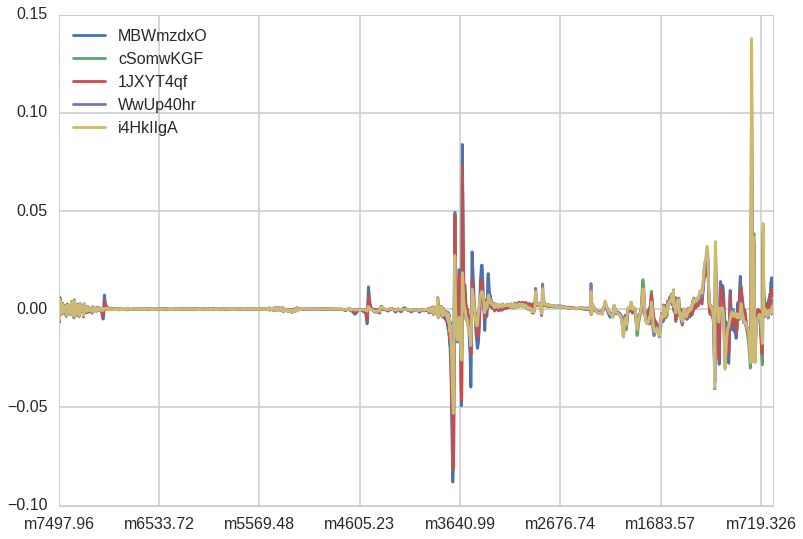

In [8]:
train_der.ix[1000].plot(label=train.PIDN[1000])
train_der.ix[1001].plot(label=train.PIDN[1001])
train_der.ix[1002].plot(label=train.PIDN[1002])
train_der.ix[1003].plot(label=train.PIDN[1003])
train_der.ix[1004].plot(label=train.PIDN[1004])
plt.legend(loc='best');

** Let's drop the first 1500 features - write a bit more expalanation as to why we want to remove those features **

In [8]:
train_der_sub = train_der[train_der.columns[1502:]]
test_der_sub = test_der[train_der.columns[1502:]]

** Split Dataset. **

In [9]:
params = {
    'test_size' : 0.2,
    'random_state' : 4
}

itrain, itest = cross_validation.split_dataset(len(train_der_sub), **params)

In [10]:
X_train, X_test = utils.get_Xs(train_der_sub, itrain, itest)

y_trains, y_tests = utils.get_Ys(y_Ca, y_P, y_Sand, y_SOC, y_pH, itrain, itest)

y_train_Ca, y_train_P, y_train_Sand, y_train_SOC, y_train_pH = y_trains
y_test_Ca, y_test_P, y_test_Sand, y_test_SOC, y_test_pH = y_tests

In [64]:
pipeline_1 = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', RandomizedPCA(n_components=100, whiten=True, random_state=7)),
        ('model', ExtraTreesRegressor(n_estimators=200, max_depth=7, n_jobs=2))
    ])

pipeline_2 = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', RandomizedPCA(n_components=100, whiten=True, random_state=7)),
        ('model', ExtraTreesRegressor(n_estimators=200, max_depth=7, n_jobs=2))
    ])

pipeline_3 = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', RandomizedPCA(n_components=100, whiten=True, random_state=7)),
        ('model', ExtraTreesRegressor(n_estimators=200, max_depth=7, n_jobs=2))
    ])

pipeline_4 = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', RandomizedPCA(n_components=100, whiten=True, random_state=7)),
        ('model', ExtraTreesRegressor(n_estimators=200, max_depth=7, n_jobs=2))
    ])

pipeline_5 = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', RandomizedPCA(n_components=100, whiten=True, random_state=7)),
        ('model', ExtraTreesRegressor(n_estimators=200, max_depth=7, n_jobs=2))
    ])

** Set up local cross-validation scheme. **

In [65]:
cv_scores = cross_validation.cv_scheme([pipeline_1, pipeline_2, pipeline_3, pipeline_4, pipeline_5],
                                        X_train, y_train_Ca, y_train_P, y_train_Sand, y_train_SOC, y_train_pH)

In [66]:
print('CV score: %f'%cv_scores)

CV score: 0.542503


** Check on the test set. **

In [67]:
pipeline_1.fit(X_train, y_train_Ca)
pipeline_2.fit(X_train, y_train_P)
pipeline_3.fit(X_train, y_train_Sand)
pipeline_4.fit(X_train, y_train_SOC)
pipeline_5.fit(X_train, y_train_pH)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', RandomizedPCA(copy=True, iterated_power=3, n_components=100, random_state=7,
       whiten=True)), ('model', ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=7,
          max_features='auto', max_leaf...timators=200, n_jobs=2, oob_score=False, random_state=None,
          verbose=0, warm_start=False))])

In [68]:
preds_Ca   = pipeline_1.predict(X_test)
preds_P    = pipeline_2.predict(X_test)
preds_Sand = pipeline_3.predict(X_test)
preds_SOC  = pipeline_4.predict(X_test)
preds_pH   = pipeline_5.predict(X_test)

In [69]:
print('MCRMSE on unseen examples: %f'%(eval_metric.mcrmse([y_test_Ca, y_test_P, y_test_Sand, y_test_SOC, y_test_pH],
                                                          [preds_Ca, preds_P, preds_Sand, preds_SOC, preds_pH])))

MCRMSE on unseen examples: 0.480936


** Training on full dataset. **

In [47]:
pipeline_1.fit(train_der_sub, y_Ca)
pipeline_2.fit(train_der_sub, y_P)
pipeline_3.fit(train_der_sub, y_Sand)
pipeline_4.fit(train_der_sub, y_SOC)
pipeline_5.fit(train_der_sub, y_pH)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', RandomizedPCA(copy=True, iterated_power=3, n_components=100, random_state=7,
       whiten=True)), ('model', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [48]:
final_preds_Ca = pipeline_1.predict(test_der_sub)
final_preds_P = pipeline_2.predict(test_der_sub)
final_preds_Sand = pipeline_3.predict(test_der_sub)
final_preds_SOC = pipeline_4.predict(test_der_sub)
final_preds_pH = pipeline_5.predict(test_der_sub)

In [49]:
sample_sub['Ca'] = final_preds_Ca
sample_sub['P'] = final_preds_P
sample_sub['Sand'] = final_preds_Sand
sample_sub['SOC'] = final_preds_SOC
sample_sub['pH'] = final_preds_pH

** Public Leaderboard:0.49878, Private Leaderboard: 0.55335 **

In [50]:
sample_sub.to_csv(os.path.join(basepath, 'submissions/derivatives_ridge.csv'), index=False)